<a href="https://colab.research.google.com/github/sweonurulu/bitirme_projesi/blob/main/akbank_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## KÜTÜPHANELER

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

from keras import layers
from keras.models import Sequential

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

In [ ]:
df=yf.download("AKBNK.IS",start="2015-01-01",end="2023-11-06")

[*********************100%%**********************]  1 of 1 completed


## EDA

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,7.425477,7.425477,7.425477,7.425477,5.485902,0
2015-01-02,7.391179,7.468349,7.365456,7.451200,5.504906,6312573
2015-01-05,7.485498,7.579817,7.485498,7.502647,5.542915,12071774
2015-01-06,7.485498,7.545519,7.468349,7.545519,5.574588,13494930
2015-01-07,7.545519,7.639838,7.502647,7.519796,5.555584,17298065


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-30,30.840000,31.280001,30.120001,30.219999,28.960285,74818809
2023-10-31,30.379999,30.740000,29.400000,29.459999,28.231964,71662383
2023-11-01,29.700001,29.940001,28.219999,29.660000,28.423628,76396792
2023-11-02,29.780001,30.360001,29.400000,30.020000,28.768623,71274321
2023-11-03,30.100000,30.180000,29.500000,30.000000,28.749456,69920777


In [ ]:
df.shape

(2265, 6)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2265.0,8.635832e+00,5.176237e+00,4.690226,6.139309e+00,6.971031e+00,8.250000e+00,3.474000e+01
High,2265.0,8.776331e+00,5.325746e+00,4.770000,6.220000e+00,7.039626e+00,8.342943e+00,3.520000e+01
Low,2265.0,8.491959e+00,5.034557e+00,4.530000,6.040000e+00,6.902435e+00,8.170000e+00,3.362000e+01
Close,2265.0,8.624684e+00,5.169311e+00,4.630205,6.130000e+00,6.962456e+00,8.250000e+00,3.448000e+01
Adj Close,2265.0,7.242571e+00,5.106857e+00,3.801046,4.876287e+00,5.485902e+00,6.684065e+00,3.304271e+01
Volume,2265.0,7.348600e+07,8.454708e+07,0.000000,2.333209e+07,4.216534e+07,9.085186e+07,9.885253e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2015-01-01 to 2023-11-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2265 non-null   float64
 1   High       2265 non-null   float64
 2   Low        2265 non-null   float64
 3   Close      2265 non-null   float64
 4   Adj Close  2265 non-null   float64
 5   Volume     2265 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.9 KB


**MISSING VALUES**

In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## TIME SERIE ANALYSIS - GRAPHS

In [ ]:
fig=go.Figure(go.Scatter(x=df.index,y=df["Close"],mode='lines', line=dict(width=1))).update_layout(
    xaxis_title="Tarih",
    yaxis_title="Hisse Kapanış Fiyatı",
    title="AKBANK Hisse Kapanış Çizgi Grafiği"
)
fig.show()

In [ ]:
fig=go.Figure(data=[
    go.Candlestick(
        close=df["Close"],
        high=df["High"],
        open=df["Open"],
        low=df["Low"],
        x=df.index
    )
]).update_layout(
    title="AKBANK Hisse D/Y Grafiği",
    xaxis_title="Tarih",
    yaxis_title="AKBNK Hisse"
)
fig.show()

**TIME SERIE DECOMPOSITION**

In [ ]:
df_close=df["Close"]

In [ ]:
decomp = seasonal_decompose(df_close,model="additive",period=60)

In [ ]:
fig=make_subplots(rows=2,cols=2,subplot_titles=("Close", "Trend", "Seasonal", "Resid"))

fig.add_trace(go.Scatter(x=df_close.index, y=df_close, mode='lines', line=dict(width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=decomp.trend.index, y=decomp.trend, mode='lines', line=dict(width=1)), row=1, col=2)
fig.add_trace(go.Scatter(x=decomp.seasonal.index, y=decomp.seasonal, mode='lines', line=dict(width=1)), row=2, col=1)
fig.add_trace(go.Scatter(x=decomp.resid.index, y=decomp.resid, mode='markers',
                         marker=dict(size=2, color=decomp.resid.apply(lambda x: 'red' if x < 0 else 'green'))), row=2, col=2)

fig.update_layout(
    showlegend=False,
    title_text="AKBNK Zaman Serisi Bileşen Analizi",
    title_x=0.5,
    yaxis=dict(title="Value"),
    coloraxis=dict(colorbar=dict(title="Residual Color")),
    height=600,
    width=1000,
)

fig.show()

**Verilerin hem trend hem de mevsimselliğe sahip olması verilerin durağan olmadığı anlamına gelir.**

In [ ]:
fig=go.Figure(go.Scatter(x=decomp.resid.index, y=decomp.resid, mode='markers',
                         marker=dict(size=2, color=decomp.resid.apply(lambda x: 'red' if x < 0 else 'green'))))
fig.show()
#pio.write_html(fig, file='akbank_resid.html')

## DURAĞANLIK SINAMA YÖNTEMLERİ / BİRİM-KÖK TESTLERİ

### ADF

In [ ]:
sm.tsa.adfuller(df_close,autolag="aic",regression="ct",maxlag=200)

(1.933806058675553,
 1.0,
 192,
 2072,
 {'1%': -3.963145893496906,
  '5%': -3.4126110287513063,
  '10%': -3.128298793203636},
 801.3497536699456)

*ADF İstatistiği*: İlk değer, ADF istatistiğini temsil eder. Bu test istatistiği, 0.5830509415283859 olarak hesaplanmıştır. ADF istatistiği, zaman serisinin durağanlık durumunu değerlendiren ana ölçüdür. Bu değer, testin hipotezi altında nasıl bir durağanlık özelliği olduğunu yansıtır.

*p-değeri*: İkinci değer, p-değerini temsil eder. Bu p-değer, 0.9969707144911633 olarak hesaplanmıştır. P-değer, ADF istatistiğinin hipotez altında rastgele üretilebilecek bir değer olasılığını ifade eder. Eğer p-değer, belirli bir alfa düzeyinin altında (genellikle 0.05) ise, birim kök hipotezi reddedilir ve zaman serisi durağan kabul edilir. Bu durumda p-değer yüksek olduğu için birim kök hipotezi reddedilmez ve zaman serisinin durağanlık özelliği kanıtlanmamıştır.

*Kullanılan Gecikmeler*: Üçüncü değer, ADF testinde kullanılan gecikmelerin sayısını temsil eder. Bu durumda, 200 gecikme kullanılmıştır.

*Gözlemler*: Dördüncü değer, analizde kullanılan toplam gözlem sayısını temsil eder. Bu kodun örnek çerçevesinde, 758 gözlem bulunmaktadır.

*Kritik Değerler*: Beşinci değer, hipotez testi için kullanılan kritik değerleri içeren bir sözlüktür. Bu kritik değerler, ADF testinin anlamlılık düzeyini (alfa) belirler ve hipotez testinin sonucunu değerlendirmek için kullanılır. Burada, 1%, 5% ve 10% anlamlılık düzeylerine sahip kritik değerler verilmiştir.

*Eleştirilen İstatistik*: Altıncı değer, ADF testinin eleştirilen istatistiğini ifade eder. Bu değer, model seçimine yardımcı olabilir ve hangi modelin daha iyi uyduğunu belirlemek için kullanılabilir.

Sonuç olarak, bu ADF testinin sonucuna göre, hisse kapanış fiyatlarından oluşan zaman serisinin durağanlık özelliği kanıtlanmamıştır. P-değer yüksektir ve belirli bir alfa düzeyinin altında olmadığı için birim kök hipotezi reddedilmez. Bu, zaman serisinin durağanlık özelliğinin olmadığını gösterir. ADF istatistiği ise bu durağanlık durumunun gücünü belirtir. Daha fazla analiz ve modelleme gerekebilir.

### KPSS

In [ ]:
sm.tsa.kpss(df_close,regression="ct",nlags="auto")

<ipython-input-111-d3f1f5817760>:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(0.9867140662059569,
 0.01,
 29,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

*KPSS istatistiği* (0.9495819475704191) kritik değerlerin altında değildir. Bu, zaman serisinin durağanlık hipotezini reddetmediği anlamına gelir. Yani, "ct" regresyon terimi kullanılarak test edilen zaman serisinin durağanlık özellikleri mevcuttur.
*P-değer* (0.01), genellikle kullanılan anlamlılık düzeyi olan 0.01'den daha düşüktür. Bu da zaman serisinin durağanlık hipotezini reddetmeye işaret eder.

### ACF

In [ ]:
acf = sm.tsa.acf(df_close, fft=True)
print(acf)

[1.         0.99441149 0.98871789 0.9832267  0.97770707 0.97180796
 0.96574852 0.95997304 0.95471139 0.94885413 0.94350731 0.9384071
 0.93299422 0.92720103 0.92127178 0.91566239 0.90994449 0.9037582
 0.89742081 0.89101791 0.88448742 0.87732223 0.86989887 0.86313053
 0.85625174 0.84922953 0.84248171 0.83599419 0.82981129 0.823547
 0.81694314 0.81058954 0.80419782 0.79828742]


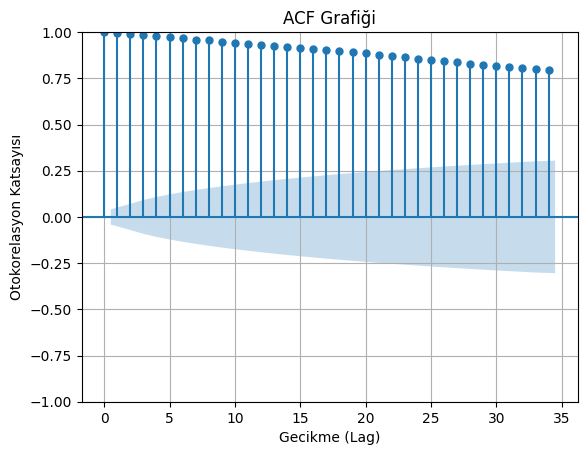

In [ ]:
# ACF grafiğini çizme
plot_acf(df_close)  # İstediğiniz gecikme (lags) sayısını belirleyebilirsiniz
plt.title('ACF Grafiği')
plt.xlabel('Gecikme (Lag)')
plt.ylabel('Otokorelasyon Katsayısı')
plt.grid(True)
plt.show()

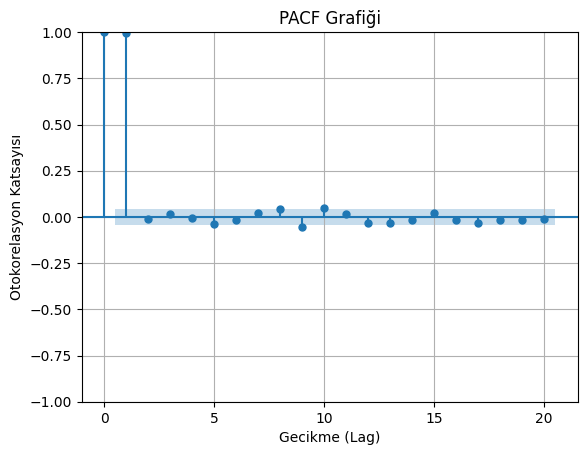

In [ ]:
# PACF grafiğini çizme
plot_pacf(df_close, lags=20)  # İstediğiniz gecikme (lags) sayısını belirleyebilirsiniz
plt.title('PACF Grafiği')
plt.xlabel('Gecikme (Lag)')
plt.ylabel('Otokorelasyon Katsayısı')
plt.grid(True)
plt.show()

## DATA

In [ ]:
# Veriyi normalize edin
scaler = MinMaxScaler(feature_range=(1,5))
scaler.fit(df)
data = scaler.transform(df)

# X ve y verilerini oluşturun
X, y = [], []

# Öğrenme penceresi boyutunu ayarlayın (örneğin, son 60 günü kullanabilirsiniz)
window_size = 60

for i in range(len(data) - window_size):
    X.append(data[i:i+window_size, 0])
    y.append(data[i+window_size, 0])

X, y = np.array(X), np.array(y)

# Eğitim ve test verilerini ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## MODELLEME

In [ ]:
ysa = Sequential()
ysa.add(layers.Dense(units=1))
ysa.add(layers.Dense(units=64, activation="relu"))
ysa.add(layers.Dense(units=32, activation="relu"))
ysa.add(layers.Dense(units=1))

# Build the model with input shape
ysa.build(input_shape=(None, 60))  # None indicates the batch size, 60 is the number of features

# Compile the model
ysa.compile(optimizer='adam', loss='mean_absolute_percentage_error')

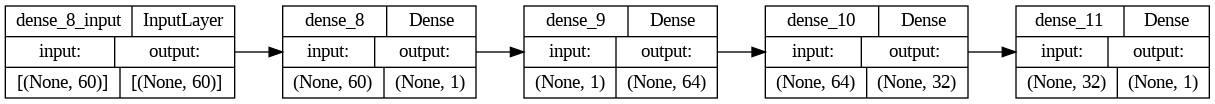

In [ ]:
from tensorflow.keras.utils import plot_model

# Modeli yatay şekilde kaydetmek için rankdir='LR' parametresini ekleyin
plot_model(ysa, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')


## EĞİTİM & TAHMİN

In [ ]:
ysa.fit(X_train,y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/20
221/221 [==============================] - 1s 3ms/step - loss: 11.0634 - val_loss: 13.0950
Epoch 2/20
221/221 [==============================] - 0s 2ms/step - loss: 5.0768 - val_loss: 11.9571
Epoch 3/20
221/221 [==============================] - 0s 2ms/step - loss: 4.2889 - val_loss: 9.1797
Epoch 4/20
221/221 [==============================] - 0s 2ms/step - loss: 3.5704 - val_loss: 7.2613
Epoch 5/20
221/221 [==============================] - 1s 3ms/step - loss: 3.2769 - val_loss: 9.7690
Epoch 6/20
221/221 [==============================] - 1s 3ms/step - loss: 2.9979 - val_loss: 5.3143
Epoch 7/20
221/221 [==============================] - 1s 3ms/step - loss: 2.7569 - val_loss: 4.7621
Epoch 8/20
221/221 [==============================] - 1s 3ms/step - loss: 2.8063 - val_loss: 4.9707
Epoch 9/20
221/221 [==============================] - 1s 3ms/step - loss: 2.6355 - val_loss: 4.4307
Epoch 10/20
221/221 [==============================] - 1s 3ms/step - loss: 2.6206 - val_loss: 4.5

In [ ]:
pred=ysa.predict(X_test)

14/14 [==============================] - 0s 2ms/step


## SONUÇ - MODEL BAŞARIM DEĞERLENDİRME

In [ ]:
mean_absolute_percentage_error(y_pred=pred,y_true=y_test)

0.04028981527772688

In [ ]:
# Tahminleri ve gerçek değerleri içeren DataFrame'i oluşturun
result_df = pd.DataFrame(data={'date': df.index[-len(y_test):], 'scaled_close': y_test.reshape(-1), 'scaled_pred_close': pred.reshape(-1)})

# Tarih sütununu indeks olarak ayarlayın
result_df.set_index('date', inplace=True)

# Matplotlib ile çizilen grafiği Plotly Graph Objects ile dönüştürme
fig = go.Figure()
fig.add_trace(go.Scatter(x=result_df.index, y=result_df['scaled_close'], mode='lines', name='Gerçek Değerler'))
fig.add_trace(go.Scatter(x=result_df.index, y=result_df['scaled_pred_close'], mode='lines', name='Tahminler'))

fig.update_layout(
    title="AKBANK Hisse Kapanış Fiyatları - Yapay Sinir Ağları ile Tahmin",
    xaxis_title="Tarih",
    yaxis_title="Değerler"
)

fig.show()


## GELECEK 3 AYLIK TAHMİN

In [ ]:
# Gelecek 3 aylık (60 iş günü) tahminler
future_steps = 60

In [ ]:
# Son eğitim verisi penceresini kullanarak tahmin yapmaya başlayacağız
last_window = X_test[-1]

In [ ]:
future_predictions = []

In [ ]:
for _ in range(future_steps):
    next_pred = ysa.predict(last_window.reshape(1, -1))
    future_predictions.append(next_pred[0, 0])
    last_window = np.append(last_window[1:], next_pred)

1/1 [==============================] - 0s 24ms/step


In [ ]:
# Tahminleri orijinal ölçeğe geri dönüştür
future_predictions = np.array(future_predictions).reshape(-1, 1)
#future_predictions = scaler.inverse_transform(future_predictions)

In [ ]:
# Gelecek tarihler
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=future_steps, freq='B')  # İş günlerini kullanarak tarihleri oluştur

In [ ]:
# Gelecek tahminleri içeren DataFrame oluşturma
future_df = pd.DataFrame(data={'date': future_dates, 'future_close': future_predictions.flatten()})

In [ ]:
# Tarih sütununu indeks olarak ayarlayın
future_df.set_index('date', inplace=True)

# Gelecek tahminleri grafiğe ekleme
fig = go.Figure()
fig.add_trace(go.Scatter(x=result_df.index, y=result_df['scaled_close'], mode='lines', name='Gerçek Değerler'))
fig.add_trace(go.Scatter(x=result_df.index, y=result_df['scaled_pred_close'], mode='lines', name='Tahminler'))
fig.add_trace(go.Scatter(x=future_df.index, y=future_df['future_close'], mode='lines', name='Gelecek Tahminler'))

fig.update_layout(
    title="AKBANK Hisse Kapanış Fiyatları - Yapay Sinir Ağları ile Tahmin ve Gelecek Projeksiyonu",
    xaxis_title="Tarih",
    yaxis_title="Değerler"
)

fig.show()